# Visualize AFOG Attacks on FRCNN
This notebook contains code for attacking a single image with AFOG on FRCNN. It also enables easy comparison between TOG, another model-agnostic attack, with AFOG. Note that FRCNN (and the other regression-based detectors) use VOC, not COCO, in our work. Please following setup instructions in README.md prior to running this notebook. This notebook is based off of https://github.com/git-disl/TOG/blob/master/demo_frcnn.ipynb

In [14]:
import os
import sys
sys.path.append(os.getcwd()[:os.getcwd().find("demos")])
from utils.dataset_utils.voc.preprocessing import letterbox_image_padded
from utils.dataset_utils.voc.eval import evaluate_dataset, evaluate_image, flag_induced_tp, evaluate_dataset_with_builtin, evaluate_dataset_with_torch
from utils.misc_utils.visualization import visualize_detections, get_gt_bboxes, graph_aps, shiftedColorMap
from models.frcnn import FRCNN
from PIL import Image
from afog.attacks import *
from tqdm import tqdm
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
%matplotlib inline
%load_ext autoreload
%autoreload 2

weights = '../model_files/FRCNN.pth'  # TODO: Change this path to the victim model's weights

detector = FRCNN().cuda(device=0).load(weights)

eps = 8 / 255.       # Hyperparameter: epsilon in L-inf norm
eps_iter = 2 / 255.  # Hyperparameter: attack learning rate
n_iter = 10          # Hyperparameter: number of attack iterations
path = "../dataset/VOCdevkit/VOC2007/JPEGImages/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Select the locations of the VOC images and the VOC annotations, and select the path of a single image. Displays the ground truth, benign predictions, and adversarial predictions under both TOG and AFOG.

<Figure size 640x480 with 0 Axes>

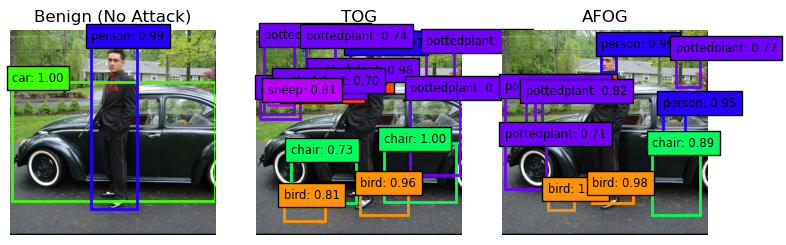

In [21]:
fpath = '../datasets/VOCdevkit/VOC2007/JPEGImages/'
annot_path = '../datasets/VOCdevkit/VOC2007/Annotations/'
im = "mancar2.jpg"

input_img = Image.open(im)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)

x_adv = tog_untargeted(detector, x_query)
detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)

x_attn = afog_cnn(detector, x_query, mode="baseline")
detections_attn = detector.detect(x_attn, conf_threshold=detector.confidence_thresh_default)

visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG': (x_adv, detections_adv, detector.model_img_size, detector.classes),
                      'AFOG': (x_attn, detections_attn, detector.model_img_size, detector.classes),
                     # 'Ground Truth': (x_query, get_gt_bboxes(annot_path, im, x_meta), detector.model_img_size, detector.classes)
                     })
